# Robestness Testing for Both Approaches

## 1. Stock Price Collection

In [3]:
import time
total_start_time = time.time()

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np

# Load stock data
ticker = 'AAPL'
start_date = '2024-06-01' 
end_date = '2025-03-10'
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Flatten the columns if they are multi-level
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = [' '.join(col).strip() for col in stock_data.columns.values]

stock_data.index = pd.to_datetime(stock_data.index)
stock_data.reset_index(inplace=True)
stock_data.rename(columns={'Close AAPL': 'Close', 'High AAPL': 'High', 'Low AAPL': 'Low', 'Open AAPL': 'Open', 'Volume AAPL': 'Volume'}, inplace=True)

stock_data['Close_log_diff'] = np.log(stock_data['Close']).diff()

stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume,Close_log_diff
0,2024-06-03,193.380066,194.336857,191.875129,192.253846,50080500,NaN
1,2024-06-04,193.699005,194.665757,192.383419,193.988027,47471400,0.001648
2,2024-06-05,195.213898,196.240446,194.217247,194.745471,54156800,0.007790
3,2024-06-06,193.828552,195.841790,193.519593,195.034506,41181800,-0.007122
4,2024-06-07,196.230484,196.280320,193.489696,193.997982,53103900,0.012316


In [5]:
# Extract the first last value for reversing the closing price predictions in the forthcoming machine learning part
actual_close_2024_12_31 = stock_data.loc[stock_data['Date']=='2024-12-31', 'Close'].values
print(actual_close_2024_12_31)

[250.14497375]


In [6]:
stock_data.describe()

,Date,Close,High,Low,Open,Volume,Close_log_diff
count,191,191.000000,191.000000,191.000000,191.000000,1.910000e+02,190.000000
mean,2024-10-18 11:18:32.041884928,228.378479,230.410694,225.854785,227.979374,5.410682e+07,0.001116
min,2024-06-03 00:00:00,192.473114,194.336857,191.506362,192.253846,2.323470e+07,-0.049366
25%,2024-08-10 12:00:00,221.951508,223.960418,219.442935,221.243072,3.885380e+07,-0.006668
50%,2024-10-17 00:00:00,227.649994,229.325284,225.314102,227.809519,4.598620e+07,0.001719
75%,2024-12-25 00:00:00,235.835403,237.648710,233.116871,234.522145,5.769605e+07,0.010041
max,2025-03-07 00:00:00,258.735504,259.814335,257.347047,257.906429,3.186799e+08,0.070131
std,NaN,12.680807,12.588588,12.809340,12.858687,3.276155e+07,0.015006


## 2. Technical Indicators Calculation

In [8]:
import numpy as np
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.volatility import AverageTrueRange

# Calculate 50-Day and 200-Day Moving Averages
stock_data['20_MA'] = stock_data['Close'].rolling(window=20).mean().shift(1)
stock_data['50_MA'] = stock_data['Close'].rolling(window=50).mean().shift(1)

# Calculate RSI
rsi = RSIIndicator(close=stock_data['Close'], window=14)
stock_data['RSI'] = rsi.rsi().shift(1)

# Calculate Bollinger Bands
bollinger = BollingerBands(close=stock_data['Close'], window=20, window_dev=2)
stock_data['Bollinger_High'] = bollinger.bollinger_hband().shift(1)
stock_data['Bollinger_Low'] = bollinger.bollinger_lband().shift(1)

# Calculate Average True Range (ATR)
atr = AverageTrueRange(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], window=14)
stock_data['ATR'] = atr.average_true_range().shift(1)

# Calculate MACD
macd = MACD(close=stock_data['Close'], window_slow=26, window_fast=12, window_sign=9)
stock_data['MACD'] = macd.macd().shift(1)
stock_data['MACD_Signal'] = macd.macd_signal().shift(1)

# Identify Support and Resistance Levels
stock_data['Support'] = stock_data['Low'].rolling(window=20).min().shift(1)
stock_data['Resistance'] = stock_data['High'].rolling(window=20).max().shift(1)

stock_data = stock_data[stock_data['Date'] >= '2025-01-02']
stock_data.head()

,Date,Close,High,Low,Open,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance
147,2025-01-02,243.582199,248.826433,241.554430,248.656607,55740700,-0.026586,249.535140,237.271641,56.715718,259.395619,239.674661,4.108714,5.096666,5.564831,238.637618,259.814335
148,2025-01-03,243.092728,243.911819,241.624341,243.092728,40244100,-0.002011,249.595075,237.424071,46.048775,259.294198,239.895952,4.428844,4.066275,5.265120,240.985041,259.814335
149,2025-01-06,244.730927,247.058369,242.932900,244.041682,45045600,0.006716,249.612556,237.579085,45.363496,259.263358,239.961755,4.275890,3.173603,4.846816,241.484495,259.814335
150,2025-01-07,241.944000,245.280328,241.084944,242.713144,40856000,-0.011453,249.710449,237.868639,48.144905,259.118424,240.302475,4.265145,2.568732,4.391199,241.484495,259.814335
151,2025-01-08,242.433441,243.442342,239.786358,241.654299,37628900,0.002021,249.678985,238.106246,44.037667,259.185917,240.172053,4.260162,1.843238,3.881607,241.084944,259.814335


In [9]:
stock_data.tail()

,Date,Close,High,Low,Open,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance
186,2025-03-03,238.029999,244.029999,236.110001,241.789993,47184000,-0.015880,238.311664,240.031363,53.476945,251.694335,224.928993,5.882832,1.918857,1.673048,225.452122,250.0
187,2025-03-04,235.929993,240.070007,234.679993,237.710007,53798100,-0.008862,238.426123,239.776678,48.446992,251.757946,225.094300,6.028344,1.517639,1.641966,225.452122,250.0
188,2025-03-05,235.740005,236.550003,229.229996,235.419998,47227600,-0.000806,238.834644,239.431245,45.885163,251.307055,226.362232,5.982749,1.018477,1.517268,226.401072,250.0
189,2025-03-06,235.330002,237.860001,233.160004,234.440002,45170400,-0.001741,238.994427,239.190494,45.649976,251.219838,226.769017,6.078267,0.600633,1.333941,227.010401,250.0
190,2025-03-07,239.070007,241.369995,234.759995,235.110001,46273600,0.015768,239.150193,238.906781,45.112591,251.102442,227.197944,5.979819,0.233711,1.113895,227.010401,250.0


stock_data.info()

In [11]:
stock_data.describe()

,Date,Close,High,Low,Open,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance
count,44,44.000000,44.000000,44.000000,44.000000,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,2025-02-04 04:21:49.090909184,236.390447,238.999810,233.397213,236.141210,5.232313e+07,-0.001029,239.196862,239.396865,46.973915,253.201168,225.192556,5.491529,-0.573405,-0.158134,224.914757,253.138182
min,2025-01-02 00:00:00,222.395477,223.873842,219.139063,219.548596,2.992530e+07,-0.041239,230.660196,237.271641,29.697295,241.037387,215.766125,4.108714,-5.558217,-3.708995,219.139063,246.918527
25%,2025-01-20 00:00:00,232.461918,233.693061,228.102330,230.926102,4.088615e+07,-0.009246,233.688776,238.873691,41.941881,247.682644,219.771738,5.126063,-2.531161,-2.632722,219.139063,247.023409
50%,2025-02-04 12:00:00,237.084999,239.911223,233.171816,236.165001,4.762045e+07,-0.000646,238.131045,239.650808,46.691919,251.420888,222.536210,5.503335,-0.674071,-0.307151,221.166834,250.000000
75%,2025-02-20 06:00:00,242.066360,245.029995,240.087270,242.808040,5.601388e+07,0.006914,245.063808,240.154531,53.299230,259.429312,227.561061,6.048948,1.862143,1.540850,227.779565,259.814335
max,2025-03-07 00:00:00,247.100006,250.000000,245.220001,248.656607,1.010751e+08,0.035892,249.710449,240.485810,63.021912,264.405561,240.302475,6.577175,5.096666,5.564831,241.484495,259.814335
std,NaN,7.028262,7.021559,7.282749,7.511536,1.653152e+07,0.017161,6.484125,0.910381,9.494320,7.389982,7.632688,0.697581,2.751282,2.694804,7.402257,5.747611


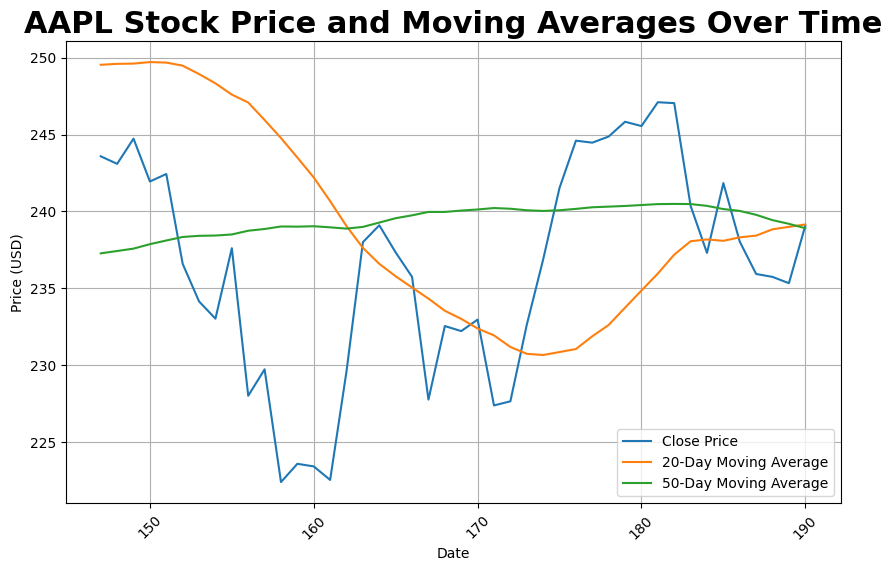

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
plt.plot(stock_data.index, stock_data['20_MA'], label='20-Day Moving Average')
plt.plot(stock_data.index, stock_data['50_MA'], label='50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('AAPL Stock Price and Moving Averages Over Time', fontsize=22, fontweight='bold')
plt.legend(loc='best') 
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig('AAPL_Stock_Price_and_Moving_Averages_over_Time_Google.png', format='png', bbox_inches='tight')
plt.show()

## 3: News Data Collection

In [14]:
import pandas as pd
news_data = pd.read_csv('apple_news_2025-01-02_to_2025-03-10.csv')
print(news_data)

        pubDate                                              title
0    02/01/2025          Why Apple (AAPL) Shares Are Sliding Today
1    03/01/2025  Apple (AAPL) Stock Falls Amid Market Uptick: W...
2    12/01/2025  Why We're Not Concerned About Apple Inc.'s (NA...
3    13/01/2025  Is Apple Inc. (AAPL) the Best NASDAQ Stock to ...
4    14/01/2025  Apple Inc. (AAPL)’s Struggle: Can AI Help Rega...
..          ...                                                ...
194  10/03/2025  Priebe Wealth Holdings LLC Raises Stock Positi...
195  10/03/2025  Apple Inc. (NASDAQ:AAPL) is Regent Peak Wealth...
196  10/03/2025  Apple Inc. (NASDAQ:AAPL) Shares Sold by Relian...
197  10/03/2025  Apple Inc. (NASDAQ:AAPL) is Culbertson A N & C...
198  10/03/2025  Apple’s (AAPL) AI Struggles Deepen as Siri Upg...

[199 rows x 2 columns]


In [15]:
news_data['pubDate'] = pd.to_datetime(news_data['pubDate'], dayfirst=True)

In [16]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  199 non-null    datetime64[ns]
 1   title    199 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.2+ KB


## 4. News Data Preprocessing

In [18]:
news_data.iloc[1]

pubDate                                  2025-01-03 00:00:00
title      Apple (AAPL) Stock Falls Amid Market Uptick: W...
Name: 1, dtype: object

In [19]:
# If a news publish date is not a stock market opening day, transform to the next opening day.
def find_nearest_date(date):
    if date not in stock_data['Date'].values:
        nearest_date = stock_data['Date'][stock_data['Date'] > date].min()
        return nearest_date if pd.notna(nearest_date) else date  # Handle case where no future date exists
    return date

news_data['pubDate'] = news_data['pubDate'].apply(find_nearest_date)
news_data

,pubDate,title
0,2025-01-02,Why Apple (AAPL) Shares Are Sliding Today
1,2025-01-03,Apple (AAPL) Stock Falls Amid Market Uptick: W...
2,2025-01-13,Why We're Not Concerned About Apple Inc.'s (NA...
3,2025-01-13,Is Apple Inc. (AAPL) the Best NASDAQ Stock to ...
4,2025-01-14,Apple Inc. (AAPL)’s Struggle: Can AI Help Rega...
...,...,...
194,2025-03-10,Priebe Wealth Holdings LLC Raises Stock Positi...
195,2025-03-10,Apple Inc. (NASDAQ:AAPL) is Regent Peak Wealth...
196,2025-03-10,Apple Inc. (NASDAQ:AAPL) Shares Sold by Relian...
197,2025-03-10,Apple Inc. (NASDAQ:AAPL) is Culbertson A N & C...


In [20]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  199 non-null    datetime64[ns]
 1   title    199 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.2+ KB


In [21]:
news_data = news_data.dropna()
news_data = news_data[news_data['title']!='NaN']
news_data = news_data.sort_values('pubDate', ascending=True).reset_index(drop=True)

In [22]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  199 non-null    datetime64[ns]
 1   title    199 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.2+ KB


In [23]:
year = news_data['pubDate'].apply(lambda x: x.year)
print(year)

0      2025
1      2025
2      2025
3      2025
4      2025
       ... 
194    2025
195    2025
196    2025
197    2025
198    2025
Name: pubDate, Length: 199, dtype: int64


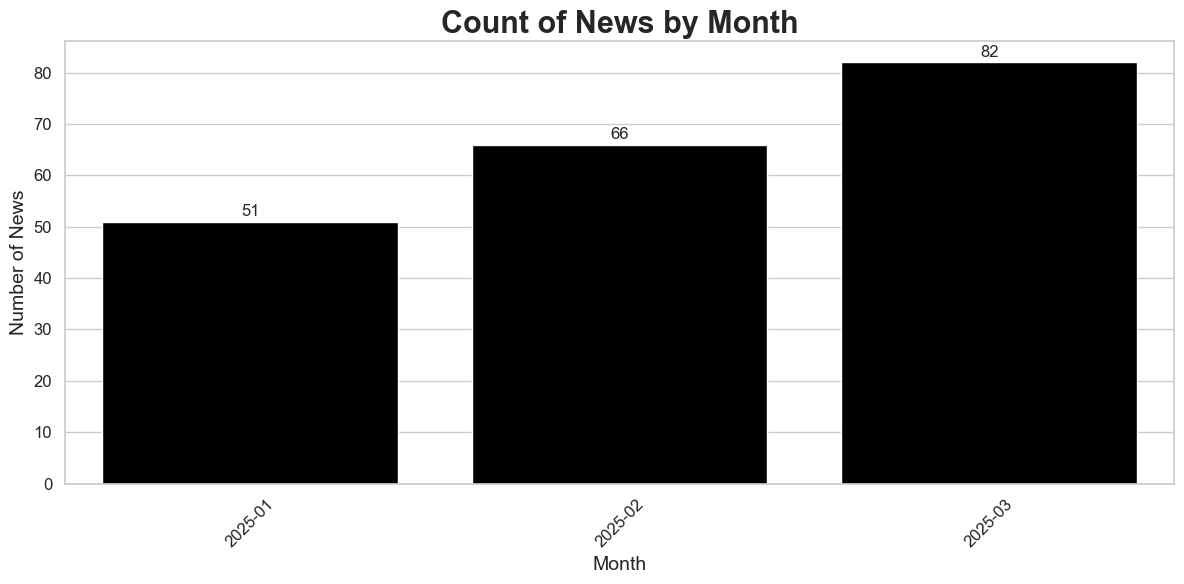

In [24]:
news_data['month'] = news_data['pubDate'].dt.to_period('M') 
pub_date_counts = news_data['month'].value_counts().sort_index()
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(x=pub_date_counts.index.astype(str), y=pub_date_counts.values, color='black')
for i, value in enumerate(pub_date_counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)
plt.title('Count of News by Month', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of News', fontsize=14)
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Count_of_News_by_Month_Google.png', format='png', bbox_inches='tight')
plt.show()

In [25]:
# 'Aggregate' the news by pubDate
news_group_by_publication_date = news_data.groupby('pubDate')['title'].apply(lambda x: '\n'.join([f'Title {i+1}: {news}' for i, news in enumerate(x)])).reset_index()
news_group_by_publication_date.columns = ['pubDate', 'titles']
news_group_by_publication_date.head()

,pubDate,titles
0,2025-01-02,Title 1: Why Apple (AAPL) Shares Are Sliding T...
1,2025-01-03,Title 1: Apple (AAPL) Stock Falls Amid Market ...
2,2025-01-13,Title 1: Why We're Not Concerned About Apple I...
3,2025-01-14,Title 1: Apple Inc. (AAPL)’s Struggle: Can AI ...
4,2025-01-15,Title 1: Apple (NASDAQ:AAPL) Seems To Use Debt...


In [26]:
news_group_by_publication_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  39 non-null     datetime64[ns]
 1   titles   39 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 756.0+ bytes


In [27]:
news_group_by_publication_date.iloc[8]['titles']

'Title 1: Jefferies Downgrades Apple Inc. (AAPL) to Underperform, Citing Weak Revenue Outlook and Subdued AI Focus'

## Approach 1: Sentiment Analysis

## 5. Sentiment Scores Generation

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
endpoint = "https://askcxksdk.openai.azure.com/"
key = "3bzSYyCIKw0vU3aIV7lqR2yGFnHybSgdde4xPRNq7OxR8B8roFAkJQQJ99BCACYeBjFXJ3w3AAAAACOGc0XS"
client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(key))

def split_text(text, max_length=5120):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

import time
from tqdm import tqdm

results = []
start_time = time.time()
for text in tqdm(news_group_by_publication_date['titles'].tolist(), desc="Processing texts", unit='text'): # Add a progress bar
    chunks = split_text(text)
    for chunk in chunks:
        response = client.analyze_sentiment(documents=[chunk])[0]
        if not response.is_error:
            sentiment = response.sentiment
            confidence_scores = response.confidence_scores
            results.append({
                'text': chunk,
                'sentiment': sentiment,
                'positive': confidence_scores.positive,
                'negative': confidence_scores.negative,
                'neutral': confidence_scores.neutral
            })
        else:
            print(f"Error processing document: {response.error.message}")
end_time = time.time()

daily_sentiment_scores = pd.DataFrame(results)

import os
file_path = 'google_news_daily_sentiment_scores.csv'

if os.path.exists(file_path):
    overwrite_message = f"File '{file_path}' exists and has been overwritten."
else:
    overwrite_message = f"File '{file_path}' does not exist. A new file will be created."
daily_sentiment_scores.to_csv(file_path, index=False)

print(overwrite_message)
print(f"Processing completed in {end_time - start_time:.2f} seconds.")

## 6. Multimodal Dataset Construction

In [35]:
daily_sentiment_scores = pd.read_csv('google_news_daily_sentiment_scores.csv')

In [36]:
daily_sentiment_scores.head()

,text,sentiment,positive,negative,neutral
0,Title 1: Why Apple (AAPL) Shares Are Sliding T...,neutral,0.03,0.44,0.53
1,Title 1: Apple (AAPL) Stock Falls Amid Market ...,neutral,0.01,0.17,0.82
2,Title 1: Why We're Not Concerned About Apple I...,positive,0.72,0.04,0.23
3,Title 1: Apple Inc. (AAPL)’s Struggle: Can AI ...,neutral,0.19,0.14,0.67
4,Title 1: Apple (NASDAQ:AAPL) Seems To Use Debt...,neutral,0.02,0.39,0.59


In [37]:
# Aggregate sentiment scores
daily_sentiment_scores['aggregated_sentiment_score'] = daily_sentiment_scores['positive'] * 1 + daily_sentiment_scores['neutral'] * 0 + daily_sentiment_scores['negative'] * (-1)
daily_sentiment_scores.drop(['sentiment', 'positive', 'negative', 'neutral'], axis=1, inplace=True)                                                                                                                                                                              
daily_sentiment_scores

,text,aggregated_sentiment_score
0,Title 1: Why Apple (AAPL) Shares Are Sliding T...,-0.41
1,Title 1: Apple (AAPL) Stock Falls Amid Market ...,-0.16
2,Title 1: Why We're Not Concerned About Apple I...,0.68
3,Title 1: Apple Inc. (AAPL)’s Struggle: Can AI ...,0.05
4,Title 1: Apple (NASDAQ:AAPL) Seems To Use Debt...,-0.37
5,Title 1: Apple Stock Falls 11%—Can AAPL Hold T...,-0.06
6,Title 1: Apple (NASDAQ:AAPL) Stock Plunges on ...,-0.74
7,Title 1: Why Is Cliff Asness Bullish On Apple ...,-0.56
8,Title 1: Jefferies Downgrades Apple Inc. (AAPL...,-0.89
9,Title 1: Greenlight Capital’s Updates on Apple...,0.02


In [38]:
# Check before inner join to see whether the primary key is okay
sum(daily_sentiment_scores['text']== news_group_by_publication_date['titles'])==len(news_group_by_publication_date)

True

In [39]:
daily_sentiment_scores = pd.merge(news_group_by_publication_date, daily_sentiment_scores, left_on='titles', right_on='text', how='inner')
daily_sentiment_scores = daily_sentiment_scores[['pubDate', 'aggregated_sentiment_score']]
daily_sentiment_scores = daily_sentiment_scores.sort_values('pubDate', ascending=True).reset_index(drop=True)
daily_sentiment_scores

,pubDate,aggregated_sentiment_score
0,2025-01-02,-0.41
1,2025-01-03,-0.16
2,2025-01-13,0.68
3,2025-01-14,0.05
4,2025-01-15,-0.37
5,2025-01-16,-0.06
6,2025-01-17,-0.74
7,2025-01-21,-0.56
8,2025-01-22,-0.89
9,2025-01-23,0.02


In [40]:
daily_sentiment_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   pubDate                     39 non-null     datetime64[ns]
 1   aggregated_sentiment_score  39 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 756.0 bytes


In [41]:
daily_sentiment_scores.describe()

,pubDate,aggregated_sentiment_score
count,39,39.000000
mean,2025-02-07 20:55:23.076923136,0.032308
min,2025-01-02 00:00:00,-0.890000
25%,2025-01-23 12:00:00,-0.100000
50%,2025-02-06 00:00:00,0.050000
75%,2025-02-25 12:00:00,0.215000
max,2025-03-10 00:00:00,0.760000
std,NaN,0.372407


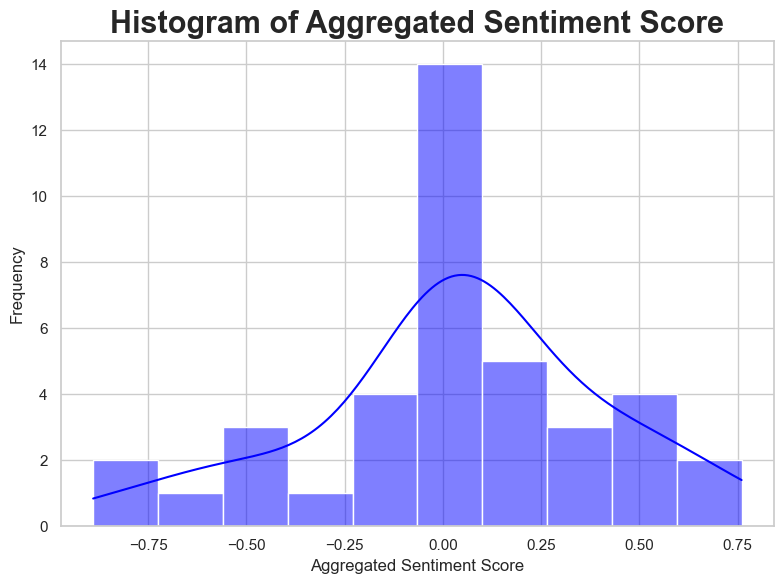

In [42]:
plt.figure(figsize=(8, 6))
sns.histplot(daily_sentiment_scores['aggregated_sentiment_score'], kde=True, color='blue', bins=10)
plt.title('Histogram of Aggregated Sentiment Score', fontsize=22, fontweight='bold')
plt.xlabel('Aggregated Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('Aggregated_Sentiment_Score_Histogram_Google.png', format='png', bbox_inches='tight')
plt.show()

In [43]:
multimodal_data = pd.merge(stock_data, daily_sentiment_scores, left_on='Date', right_on='pubDate', how='left')
multimodal_data = multimodal_data.sort_values('Date', ascending=True).reset_index(drop=True)
multimodal_data.drop(['High', 'Low', 'Open', 'pubDate'], axis=1, inplace=True)
multimodal_data

,Date,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,aggregated_sentiment_score
0,2025-01-02,243.582199,55740700,-0.026586,249.535140,237.271641,56.715718,259.395619,239.674661,4.108714,5.096666,5.564831,238.637618,259.814335,-0.41
1,2025-01-03,243.092728,40244100,-0.002011,249.595075,237.424071,46.048775,259.294198,239.895952,4.428844,4.066275,5.265120,240.985041,259.814335,-0.16
2,2025-01-06,244.730927,45045600,0.006716,249.612556,237.579085,45.363496,259.263358,239.961755,4.275890,3.173603,4.846816,241.484495,259.814335,NaN
3,2025-01-07,241.944000,40856000,-0.011453,249.710449,237.868639,48.144905,259.118424,240.302475,4.265145,2.568732,4.391199,241.484495,259.814335,NaN
4,2025-01-08,242.433441,37628900,0.002021,249.678985,238.106246,44.037667,259.185917,240.172053,4.260162,1.843238,3.881607,241.084944,259.814335,NaN
5,2025-01-10,236.589874,61710900,-0.024399,249.476707,238.336878,44.926262,259.409969,239.543445,4.217007,1.292870,3.363860,239.786358,259.814335,NaN
6,2025-01-13,234.142563,49630700,-0.010398,248.931306,238.410927,37.309220,260.329148,237.533465,4.607888,0.380782,2.767244,232.744097,259.814335,0.68
7,2025-01-14,233.023788,39435300,-0.004790,248.327470,238.430641,34.658909,261.393560,235.261381,4.787479,-0.533383,2.107119,229.467710,259.814335,0.05
8,2025-01-15,237.608749,39832000,0.019485,247.594276,238.499223,33.487779,262.268439,232.920113,4.705944,-1.332778,1.419140,229.467710,259.814335,-0.37
9,2025-01-16,228.009308,71759100,-0.041239,247.081839,238.743120,42.119548,262.385727,231.777951,4.775075,-1.578144,0.819683,229.467710,259.814335,-0.06


In [44]:
multimodal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        44 non-null     datetime64[ns]
 1   Close                       44 non-null     float64       
 2   Volume                      44 non-null     int64         
 3   Close_log_diff              44 non-null     float64       
 4   20_MA                       44 non-null     float64       
 5   50_MA                       44 non-null     float64       
 6   RSI                         44 non-null     float64       
 7   Bollinger_High              44 non-null     float64       
 8   Bollinger_Low               44 non-null     float64       
 9   ATR                         44 non-null     float64       
 10  MACD                        44 non-null     float64       
 11  MACD_Signal                 44 non-null     float64       
 

In [45]:
multimodal_data['aggregated_sentiment_score'].notnull().value_counts()

aggregated_sentiment_score
True     36
False     8
Name: count, dtype: int64

## 7. Multimodal Dataset Preprocessing

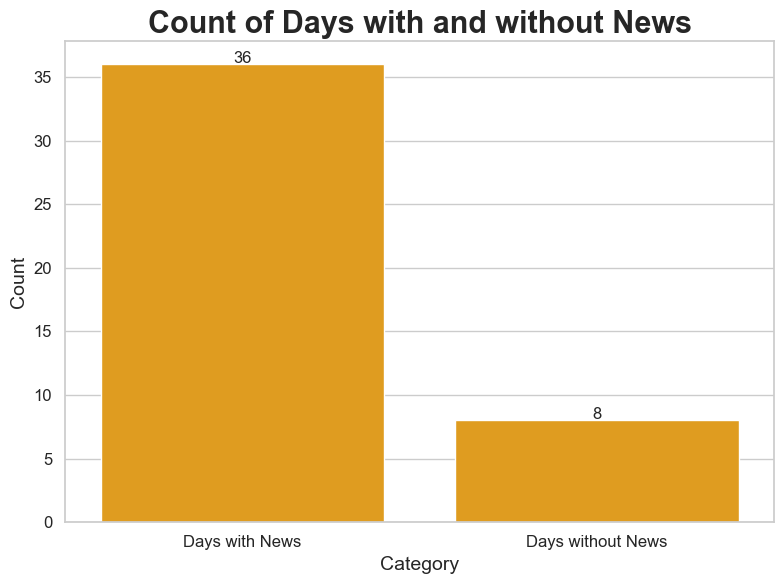

In [47]:
counts = multimodal_data['aggregated_sentiment_score'].notnull().value_counts()
counts.index = ["Days with News", "Days without News"]
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=counts.index, y=counts.values, color='orange')
for i, count in enumerate(counts.values):
    ax.text(i, count + 0.1, str(count), ha='center', fontsize=12)
plt.title("Count of Days with and without News", fontsize=22, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Count_of_Days_with_and_without_News_Google.png', format='png', bbox_inches='tight')
plt.show()

In [48]:
# Apply exponential decay to Aggregated Sentiment Scores to fill in the time gap
multimodal_data.set_index('Date', inplace=True)
decay_factor = 0.03

def fill_missing_sentiment(df):
    # Iterate over the DataFrame to fill missing values
    for i in range(len(df)):
        if pd.isna(df['aggregated_sentiment_score'].iloc[i]):
            # Find the last known sentiment score (S(0)) using .loc
            last_known_index = df['aggregated_sentiment_score'][:df.index[i]].last_valid_index()
            if last_known_index is not None:
                S_0 = df.loc[last_known_index, 'aggregated_sentiment_score']
                # Calculate time (t) as the number of days since the last known sentiment score
                t = (df.index[i] - last_known_index).days
                # Apply the exponential decay formula
                S_t = 3 + (S_0 - 3) * np.exp(-decay_factor * t)
                df.loc[df.index[i], 'aggregated_sentiment_score'] = S_t
    return df

multimodal_data = fill_missing_sentiment(multimodal_data)

In [49]:
# Fill missing values of all columns with their corresponding averages
average_values = multimodal_data['aggregated_sentiment_score'].mean()
multimodal_data['aggregated_sentiment_score'] = multimodal_data['aggregated_sentiment_score'].fillna(average_values)
multimodal_data

,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,aggregated_sentiment_score
Date,,,,,,,,,,,,,,
2025-01-02,243.582199,55740700,-0.026586,249.535140,237.271641,56.715718,259.395619,239.674661,4.108714,5.096666,5.564831,238.637618,259.814335,-0.410000
2025-01-03,243.092728,40244100,-0.002011,249.595075,237.424071,46.048775,259.294198,239.895952,4.428844,4.066275,5.265120,240.985041,259.814335,-0.160000
2025-01-06,244.730927,45045600,0.006716,249.612556,237.579085,45.363496,259.263358,239.961755,4.275890,3.173603,4.846816,241.484495,259.814335,0.111977
2025-01-07,241.944000,40856000,-0.011453,249.710449,237.868639,48.144905,259.118424,240.302475,4.265145,2.568732,4.391199,241.484495,259.814335,0.197331
2025-01-08,242.433441,37628900,0.002021,249.678985,238.106246,44.037667,259.185917,240.172053,4.260162,1.843238,3.881607,241.084944,259.814335,0.280163
2025-01-10,236.589874,61710900,-0.024399,249.476707,238.336878,44.926262,259.409969,239.543445,4.217007,1.292870,3.363860,239.786358,259.814335,0.438554
2025-01-13,234.142563,49630700,-0.010398,248.931306,238.410927,37.309220,260.329148,237.533465,4.607888,0.380782,2.767244,232.744097,259.814335,0.680000
2025-01-14,233.023788,39435300,-0.004790,248.327470,238.430641,34.658909,261.393560,235.261381,4.787479,-0.533383,2.107119,229.467710,259.814335,0.050000
2025-01-15,237.608749,39832000,0.019485,247.594276,238.499223,33.487779,262.268439,232.920113,4.705944,-1.332778,1.419140,229.467710,259.814335,-0.370000


In [50]:
multimodal_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2025-01-02 to 2025-03-07
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Close                       44 non-null     float64
 1   Volume                      44 non-null     int64  
 2   Close_log_diff              44 non-null     float64
 3   20_MA                       44 non-null     float64
 4   50_MA                       44 non-null     float64
 5   RSI                         44 non-null     float64
 6   Bollinger_High              44 non-null     float64
 7   Bollinger_Low               44 non-null     float64
 8   ATR                         44 non-null     float64
 9   MACD                        44 non-null     float64
 10  MACD_Signal                 44 non-null     float64
 11  Support                     44 non-null     float64
 12  Resistance                  44 non-null     float64
 13  aggregated_sentim

In [51]:
multimodal_data.describe()

,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,aggregated_sentiment_score
count,44.000000,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,236.390447,5.232313e+07,-0.001029,239.196862,239.396865,46.973915,253.201168,225.192556,5.491529,-0.573405,-0.158134,224.914757,253.138182,0.081635
std,7.028262,1.653152e+07,0.017161,6.484125,0.910381,9.494320,7.389982,7.632688,0.697581,2.751282,2.694804,7.402257,5.747611,0.368571
min,222.395477,2.992530e+07,-0.041239,230.660196,237.271641,29.697295,241.037387,215.766125,4.108714,-5.558217,-3.708995,219.139063,246.918527,-0.890000
25%,232.461918,4.088615e+07,-0.009246,233.688776,238.873691,41.941881,247.682644,219.771738,5.126063,-2.531161,-2.632722,219.139063,247.023409,-0.045000
50%,237.084999,4.762045e+07,-0.000646,238.131045,239.650808,46.691919,251.420888,222.536210,5.503335,-0.674071,-0.307151,221.166834,250.000000,0.085000
75%,242.066360,5.601388e+07,0.006914,245.063808,240.154531,53.299230,259.429312,227.561061,6.048948,1.862143,1.540850,227.779565,259.814335,0.302622
max,247.100006,1.010751e+08,0.035892,249.710449,240.485810,63.021912,264.405561,240.302475,6.577175,5.096666,5.564831,241.484495,259.814335,0.760000


## 8. Machine Learning

In [53]:
X_test = multimodal_data.drop('Close', axis=1).values
y_test = multimodal_data['Close'].to_numpy()

In [54]:
test_actual_close = multimodal_data['Close'].values.reshape(-1, 1)
print(test_actual_close.shape)

(44, 1)


In [55]:
X_test = multimodal_data.drop(['Close', 'Close_log_diff'], axis=1).values
y_test = multimodal_data['Close_log_diff'].to_numpy()

In [56]:
test_predictions_last_close = np.concatenate((actual_close_2024_12_31, multimodal_data[:-1]['Close'].values)).reshape(-1, 1)
print(test_predictions_last_close.shape)

(44, 1)


In [57]:
from sklearn.preprocessing import MinMaxScaler

# Initialize separate scalers for X and y
scaler_X = MinMaxScaler()  # For independent variables
scaler_y = MinMaxScaler()  # For dependent variable

# Fit and transform X_train and y_train
X_test_scaled = scaler_X.fit_transform(X_test)
y_test_scaled = scaler_y.fit_transform(y_test.reshape(-1, 1))  

# Print shapes to verify correctness
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")

X_test_scaled shape: (44, 12)
y_test_scaled shape: (44, 1)


In [58]:
results = []

In [59]:
def supervised_model_reverse_scaling(test_forecast_scaled, reverse_min_max_scaling):
    """
    Reverse scaling and compute adjusted close forecasts for test data.

    Parameters:
        test_forecast_scaled (numpy.ndarray): Scaled test forecast values.

    Returns:
        numpy.ndarray: Adjusted close forecasts for the test data.
    """
    # Reverse scaling for test data
    if reverse_min_max_scaling==True:
        test_forecast = scaler_y.inverse_transform(test_forecast_scaled.reshape(-1, 1))
    else:
        test_forecast = test_forecast_scaled
    test_close_forecast = np.exp(np.log(test_predictions_last_close) + test_forecast)

    return test_close_forecast

In [60]:
from sklearn.metrics import mean_squared_error

def supervised_model_evaluation(test_forecast_scaled, reverse_min_max_scaling):
    """
    Evaluate the supervised model by calculating MSE and percentage loss for test data.

    This function reverses the scaling of forecasted test values, computes the Mean Squared Error (MSE), 
    and calculates the percentage loss for the test dataset.

    Parameters:
        test_forecast_scaled (numpy.ndarray): Scaled forecast values for the test data.

    Returns:
        tuple: A tuple containing:
            - test_mse (float): Mean Squared Error for the test data.
            - test_percentage_loss (float): Percentage loss for the test data.
    """
    # Rescaling
    test_close_forecast = supervised_model_reverse_scaling(test_forecast_scaled, reverse_min_max_scaling)

    # Calculate MSE
    test_mse = mean_squared_error(test_actual_close, test_close_forecast)

    # Calculate percentage loss
    test_percentage_loss = np.mean(np.abs((test_actual_close - test_close_forecast) / test_actual_close)) * 100

    return test_mse, test_percentage_loss

In [61]:
def print_results(test_mse, test_percentage_loss, total_time):
    """
    Print the evaluation results of the supervised model for test data.

    This function displays the test loss (unscaled), percentage loss, 
    and the total runtime of the model evaluation.

    Parameters:
        test_mse (float): Mean Squared Error for the test data.
        test_percentage_loss (float): Percentage loss for the test data.
        total_time (float): Total runtime of the evaluation process in seconds.

    Returns:
        None
    """
    print(f"Test Loss (unscaled): {test_mse:.4f}")
    print(f"Test Percentage Loss: {test_percentage_loss:.2f}%")
    print(f"Total runtime: {total_time:.4f} seconds")

In [62]:
import time
import joblib

def supervised_model_test(file, model_name, X_test_scaled, reverse_min_max_scaling=True):
    """
    Test a saved supervised model on test data and evaluate its performance.

    This function loads a previously saved model from a file, makes predictions on the 
    scaled test dataset, evaluates its performance using MSE and percentage loss metrics, 
    and records the results along with the total runtime.

    Parameters:
        file (str): File path to the saved model.
        model_name (str): Name of the model (used for logging results).

    Returns:
        None
    """
    start_time = time.time()
    model = joblib.load(file) #Load the saved model
    test_predictions_scaled = model.predict(X_test_scaled).reshape(-1, 1)

    test_mse, test_percentage_loss = supervised_model_evaluation(test_predictions_scaled, reverse_min_max_scaling)

    end_time = time.time()
    total_time = end_time - start_time

    results.append([model_name, test_mse, test_percentage_loss, total_time])

    print_results(test_mse, test_percentage_loss, total_time)

In [63]:
def deep_learning_reverse_scaling(test_forecast_scaled):
    """
    Reverse scaling and compute adjusted close forecasts for test data in a deep learning model.

    This function applies inverse scaling to the scaled test forecast data and computes 
    the adjusted close forecasts using exponential transformations.

    Parameters:
        test_forecast_scaled (numpy.ndarray): Scaled forecast values for the test data.

    Returns:
        numpy.ndarray: Adjusted close forecasts for the test data.
    """
    # Reverse scaling for test data
    test_forecast = scaler_y.inverse_transform(test_forecast_scaled.reshape(-1, 1))
    test_close_forecast = np.exp(np.log(test_predictions_last_close[(len(test_predictions_last_close)-len(X_test_tensor)):]) + test_forecast)

    return test_close_forecast

In [64]:
def deep_learning_model_evaluation(test_forecast_scaled):
    """
    Evaluate a deep learning model by calculating MSE and percentage loss for test data.

    This function reverses the scaling of forecasted test values, computes the Mean Squared Error (MSE), 
    and calculates the percentage loss for the test dataset.

    Parameters:
        test_forecast_scaled (numpy.ndarray): Scaled forecast values for the test data.

    Returns:
        tuple: A tuple containing:
            - test_mse (float): Mean Squared Error for the test data.
            - test_percentage_loss (float): Percentage loss for the test data.
    """
    test_close_forecast = deep_learning_reverse_scaling(test_forecast_scaled)

    # Calculate MSE
    test_mse = mean_squared_error(test_actual_close[(len(test_predictions_last_close)-len(X_test_tensor)):], test_close_forecast)

    # Calculate percentage losses
    test_percentage_loss = np.mean(np.abs((test_actual_close[(len(test_predictions_last_close)-len(X_test_tensor)):] - test_close_forecast) / test_actual_close[(len(test_predictions_last_close)-len(X_test_tensor)):])) * 100

    return test_mse, test_percentage_loss

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

def deep_learning_test(model_name, file, X_test_tensor):
    """
    Test a saved deep learning model on test data and evaluate its performance.

    This function loads a previously saved PyTorch model from a file, makes predictions 
    on the test dataset, evaluates its performance using Mean Squared Error (MSE) and 
    percentage loss metrics, and logs the results.

    Parameters:
        model_name (str): Name of the model (used for logging results). Supports "Transformer" for special handling.
        file (str): File path to the saved model.
        X_test_tensor (torch.Tensor): Input features for the test data as a PyTorch tensor.

    Returns:
        None
    """
    # Load the entire model
    model = torch.load(file, weights_only=False)
    print("Model loaded successfully!")
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()

    # Evaluation on test data
    model.eval()
    with torch.no_grad():
    
        # Predictions on test data
        if model_name=="Transformer":
            test_predictions_scaled = model(X_test_tensor.unsqueeze(1)).detach().numpy()
            test_predictions_scaled_2d = test_predictions_scaled.reshape(-1, test_predictions_scaled.shape[-1]).flatten()
            
        else:
            test_predictions_scaled = model(X_test_tensor).detach().numpy()
            test_predictions_scaled_2d = test_predictions_scaled.reshape(-1, test_predictions_scaled.shape[-1])  # Flatten to 2D

        test_mse, test_percentage_loss = deep_learning_model_evaluation(test_predictions_scaled)

    end_time = time.time()
    total_time = end_time - start_time

    results.append([model_name, test_mse, test_percentage_loss, total_time])

    print_results(test_mse, test_percentage_loss, total_time)

### Random Walk

In [67]:
start_time = time.time()

# Random walk forecast for test data (using last training value as starting point)
test_forecast_scaled = np.zeros_like(y_test_scaled)
test_forecast_scaled[0] = y_test_scaled[0]  # First value is set to the first actual value
test_forecast_scaled[1:] = y_test_scaled[:-1]  # Use lagged values from the test set

test_mse, test_percentage_loss = supervised_model_evaluation(test_forecast_scaled, reverse_min_max_scaling=True)

end_time = time.time()
total_time = end_time - start_time

results.append(["Random Walk", test_mse, test_percentage_loss, total_time])

print_results(test_mse, test_percentage_loss, total_time)

Test Loss (unscaled): 29.8060
Test Percentage Loss: 1.79%
Total runtime: 0.0020 seconds


### ARIMA

In [69]:
import pickle

start_time = time.time()

# Load the saved ARIMA model
with open('arima_model.pkl', 'rb') as file:
    loaded_arima_model = pickle.load(file)

# Load the best order (optional, for reference)
with open('best_order.pkl', 'rb') as file:
    loaded_best_order = pickle.load(file)

print(f"Loaded ARIMA model with best order: {loaded_best_order}")

test_forecast_scaled = loaded_arima_model.forecast(steps=len(y_test_scaled))

test_mse, test_percentage_loss = supervised_model_evaluation(test_forecast_scaled, reverse_min_max_scaling=True)

end_time = time.time()
total_time = end_time - start_time

results.append(['ARIMA' + str(loaded_best_order), test_mse, test_percentage_loss, total_time])

print_results(test_mse, test_percentage_loss, total_time)

Loaded ARIMA model with best order: (2, 0, 2)
Test Loss (unscaled): 19.3092
Test Percentage Loss: 1.53%
Total runtime: 0.6059 seconds


### Lasso

In [71]:
# Load and test the best model
supervised_model_test('lasso_model.pkl', "Lasso", X_test_scaled, reverse_min_max_scaling=True)

Test Loss (unscaled): 19.0161
Test Percentage Loss: 1.52%
Total runtime: 0.3261 seconds


### Elastic Net

In [73]:
# Load and test the best model
supervised_model_test('elastic_net_model.pkl', "Elastic Net", X_test_scaled, reverse_min_max_scaling=True)

Test Loss (unscaled): 18.9112
Test Percentage Loss: 1.51%
Total runtime: 0.0246 seconds


### Support Vector

In [75]:
# Load and test the best model
supervised_model_test('support_vector_model.pkl', "Support Vector", X_test_scaled, reverse_min_max_scaling=True)

Test Loss (unscaled): 18.3791
Test Percentage Loss: 1.49%
Total runtime: 0.2519 seconds


### k-Nearest Neighbors

In [77]:
# Load and test the best model
supervised_model_test('knn_model.pkl', "k-Nearest Neighbors", X_test_scaled, reverse_min_max_scaling=True)

Test Loss (unscaled): 18.4724
Test Percentage Loss: 1.51%
Total runtime: 0.4583 seconds


### Random Forest

In [79]:
# Load and test the best model
supervised_model_test('random_forest_model.pkl', "Random Forest", X_test, reverse_min_max_scaling=False)

Test Loss (unscaled): 14.7121
Test Percentage Loss: 1.30%
Total runtime: 0.6779 seconds


### Adaboost

In [81]:
# Load and test the best model
supervised_model_test('adaboost_model.pkl', "Adaboost", X_test, reverse_min_max_scaling=False)

Test Loss (unscaled): 16.5016
Test Percentage Loss: 1.31%
Total runtime: 0.0506 seconds


### Gradient Boosting

In [83]:
# Load and test the best model
supervised_model_test('gradient_boosting_model.pkl', "Gradient Boosting", X_test, reverse_min_max_scaling=False)

Test Loss (unscaled): 15.6999
Test Percentage Loss: 1.28%
Total runtime: 0.0353 seconds


### LightGBM

In [85]:
# Load and test the best model
supervised_model_test('lightgbm_model.pkl', "LightGBM", X_test, reverse_min_max_scaling=False)

Test Loss (unscaled): 15.7022
Test Percentage Loss: 1.26%
Total runtime: 3.4505 seconds


### CatBoost

In [87]:
# Load and test the best model
supervised_model_test('catboost_model.pkl', "CatBoost", X_test, reverse_min_max_scaling=False)

Test Loss (unscaled): 15.2205
Test Percentage Loss: 1.24%
Total runtime: 0.3869 seconds


### XGBoost

In [89]:
# Load and test the best model
supervised_model_test('xgboost_model.pkl', "XGBoost", X_test, reverse_min_max_scaling=False)

Test Loss (unscaled): 15.9839
Test Percentage Loss: 1.28%
Total runtime: 0.0691 seconds


### N-BEATS

In [91]:
# Convert to PyTorch tensors 
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [92]:
# Define N-BEATS model
class NBEATS(nn.Module):
    def __init__(self, input_size=X_test_tensor.shape[1], hidden_size=64, num_blocks=3, num_layers=2, dropout=0.1):
        super(NBEATS, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(NBEATSBlock(input_size, hidden_size, num_layers, dropout))
        self.fc_out = nn.Linear(hidden_size, 1)  # Final output layer

    def forward(self, x):
        residual = x
        for block in self.blocks:
            block_output = block(residual)
            # Project block output back to input size for residual connection
            projected_output = block_output[:, :residual.shape[1]]  # Match dimensions
            residual = residual - projected_output  # Residual connection
        return self.fc_out(block_output)

class NBEATSBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(NBEATSBlock, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size if _ == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc_layers(x)

In [93]:
# Load the best model and test
deep_learning_test("N-BEATS", 'nbeats_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 14.5137
Test Percentage Loss: 1.27%
Total runtime: 0.0086 seconds


### N-HiTS

In [95]:
# Convert tensors to PyTorch format 
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [96]:
# Define N-HiTS model
class NHiTS(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_blocks=3, num_layers=2, dropout=0.1, pool_sizes=[4, 2, 1]):
        super(NHiTS, self).__init__()
        
        self.blocks = nn.ModuleList()
        for pool_size in pool_sizes:
            self.blocks.append(NHiTSBlock(input_size, hidden_size, num_layers, dropout, pool_size))
        
        self.fc_out = nn.Linear(hidden_size, 1)  # Final output layer

    def forward(self, x):
        # Add a singleton dimension to make x 3D: (batch_size, sequence_length) -> (batch_size, sequence_length, 1)
        x = x.unsqueeze(-1)  # Shape: (batch_size, sequence_length, 1)
        
        residual = x
        for block in self.blocks:
            backcast, forecast = block(residual)
            # Project backcast back to input feature size for residual connection
            residual = residual - backcast  # Shape: (batch_size, sequence_length, 1)
        
        # Apply final output layer to the forecast from the last block
        # forecast shape: (batch_size, reduced_seq_length, hidden_size)
        output = self.fc_out(forecast)  # Shape: (batch_size, reduced_seq_length, 1)
        
        # Aggregate over the sequence length to get a single prediction per sample
        output = output.mean(dim=1)  # Shape: (batch_size, 1)
        return output  # Shape: (batch_size, 1)

class NHiTSBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, pool_size):
        super(NHiTSBlock, self).__init__()
        
        layers = []
        for _ in range(num_layers):
            # Input size is 1 for the first layer (since we added a singleton dimension)
            layers.append(nn.Linear(1 if _ == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        self.fc_layers = nn.Sequential(*layers)
        
        # Pooling layer to handle multi-rate forecasting
        self.pool = nn.AvgPool1d(kernel_size=pool_size, stride=pool_size)
        
        # Output projection layers
        self.backcast_fc = nn.Linear(hidden_size, 1)  # Backcast for residual (matches feature dim = 1)
        self.forecast_fc = nn.Linear(hidden_size, hidden_size)  # Forecast retains hidden_size for final layer

    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        x = self.fc_layers(x)  # Shape: (batch_size, sequence_length, hidden_size)
        
        # Apply pooling to capture multi-rate patterns
        x_pooled = self.pool(x.permute(0, 2, 1)).permute(0, 2, 1)  # Shape: (batch_size, reduced_seq_length, hidden_size)
        
        # Generate backcast (for residual) and forecast
        backcast = self.backcast_fc(x)  # Shape: (batch_size, sequence_length, 1)
        forecast = self.forecast_fc(x_pooled)  # Shape: (batch_size, reduced_seq_length, hidden_size)
        
        return backcast, forecast

In [97]:
# Load the best model and test
deep_learning_test("N-HiTS", 'nhits_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 18.2875
Test Percentage Loss: 1.48%
Total runtime: 0.0040 seconds


### LSTM

In [99]:
# Prepare data
sequence_length = 10
num_features = X_test_scaled.shape[1]  # Use scaled X_train

# Reshape X_test_scaled and y_test_scaled to (samples, sequence_length, num_features)
X_test_reshaped = []
y_test_reshaped = []

for i in range(len(X_test_scaled) - sequence_length):
    X_test_reshaped.append(X_test_scaled[i:i+sequence_length])  # Use scaled X
    y_test_reshaped.append(y_test_scaled[i+sequence_length])    # Use scaled y

X_test_reshaped = np.array(X_test_reshaped)
y_test_reshaped = np.array(y_test_reshaped)

# Convert reshaped data to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test_reshaped).float()
y_test_tensor = torch.from_numpy(y_test_reshaped).float().reshape(-1, 1)   # Ensure correct shape for y

# Print shapes for verification
print("X_test_tensor shape:", X_test_tensor.shape)    # Expected: (samples, sequence_length, num_features)
print("y_test_tensor shape:", y_test_tensor.shape)    # Expected: (samples, 1)

X_test_tensor shape: torch.Size([34, 10, 12])
y_test_tensor shape: torch.Size([34, 1])


In [100]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=X_test_tensor.shape[2], hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])
        
torch._dynamo.config.suppress_errors = True

In [101]:
# Load the best model and test
deep_learning_test("LSTM", 'lstm_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 19.9643
Test Percentage Loss: 1.57%
Total runtime: 0.0140 seconds


### Transformer

In [103]:
# Convert to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1])


In [104]:
# Define Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size=X_test_tensor.shape[1], d_model=64, nhead=4, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)  # Project input to d_model dimension
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(d_model, 1)  # Final output layer

    def forward(self, src):
        # Project input and add positional encoding
        src = self.input_projection(src)
        src = self.positional_encoding(src)

        # Pass through Transformer encoder
        encoded_output = self.transformer_encoder(src)

        # Pass through final fully connected layer
        return self.fc_out(encoded_output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [105]:
# Load the best model and test
deep_learning_test("Transformer", 'transformer_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 18.9946
Test Percentage Loss: 1.53%
Total runtime: 0.0060 seconds


### Patch TST

In [107]:
# Convert to PyTorch tensors 
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [108]:
# Define PatchTST model
class PatchTST(nn.Module):
    def __init__(self, input_size=X_test_tensor.shape[1], hidden_size=64, n_heads=4, n_layers=2, dropout=0.1):
        super(PatchTST, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)  # No patching required
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=n_heads, dropout=dropout, batch_first=True 
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc_out = nn.Linear(hidden_size, 1)  # Output a single value for regression

    def forward(self, x):
        # Embedding and encoding
        x = self.embedding(x)  # Shape: (batch_size, hidden_size)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)  # Add seq_len dimension for Transformer
        x = self.fc_out(x)     # Output layer
        return x

In [109]:
# Load the best model and test
deep_learning_test("PatchTST", 'patchtst_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 15.9889
Test Percentage Loss: 1.35%
Total runtime: 0.0070 seconds


### Autoformer

In [111]:
# Convert to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test_scaled).float().unsqueeze(-1)  
y_test_tensor = torch.from_numpy(y_test_scaled).float()
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12, 1])
y_test_tensor shape: torch.Size([44, 1])


In [112]:
# Define Autoformer model
class DecompositionBlock(nn.Module):
    def __init__(self, kernel_size):
        super(DecompositionBlock, self).__init__()
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        # Ensure input has 3 dimensions: (batch_size, seq_len, input_dim)
        if x.dim() != 3:
            raise ValueError(f"Expected input with 3 dimensions (batch_size, seq_len, input_dim), but got {x.shape}")
        
        # Apply moving average for trend extraction
        trend = self.moving_avg(x.transpose(1, 2)).transpose(1, 2)
        seasonal = x - trend
        return seasonal, trend


class Autoformer(nn.Module):
    def __init__(self, input_dim=X_test_tensor.shape[2], nhead=4, hidden_dim=64, seq_len=X_test_tensor.shape[1], pred_len=y_test_tensor.shape[1], kernel_size=3):
        super(Autoformer, self).__init__()
        self.decomposition = DecompositionBlock(kernel_size)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True), num_layers=2,
        )
        self.decoder = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # Decompose input into seasonal and trend components
        seasonal, trend = self.decomposition(x)
        
        # Encode seasonal component
        x = self.embedding(seasonal)  # Shape: (batch_size, seq_len, hidden_dim)
        x = self.encoder(x)          # Shape: (batch_size, seq_len, hidden_dim)
        
        # Decode to prediction
        x = self.decoder(x[:, -1])   # Use only the last time step for prediction
        return x + trend[:, -1]      # Add back the trend component

In [113]:
# Load the best model and test
deep_learning_test("Autoformer", 'autoformer_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 23.5765
Test Percentage Loss: 1.73%
Total runtime: 0.0152 seconds


### LightTS

In [115]:
# Convert to PyTorch tensors 
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [116]:
# Define LightTS model
class LightTS(nn.Module):
    def __init__(self, input_dim=X_test_tensor.shape[1], hidden_dim=64, output_dim=1, num_layers=2, dropout=0.1):
        super(LightTS, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # Define a simple feedforward network with dropout
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [117]:
# Load the best model and test
deep_learning_test("LightTS", 'lightts_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 15.9438
Test Percentage Loss: 1.32%
Total runtime: 0.0050 seconds


### TiDE

In [119]:
# Convert to PyTorch tensors 
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [120]:
# Define TiDE model
class TiDE(nn.Module):
    def __init__(self, input_dim=X_test_tensor.shape[1], hidden_dim=64, output_dim=1, num_layers=2, dropout=0.1):
        super(TiDE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            *[nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)) for _ in range(num_layers - 1)]
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [121]:
# Load the best model and test
deep_learning_test("TiDE", 'tide_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 17.7567
Test Percentage Loss: 1.46%
Total runtime: 0.0049 seconds


### DLinear

In [123]:
# Convert to PyTorch tensors 
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [124]:
# Define DLinear model
class DLinear(nn.Module):
    def __init__(self, input_dim=X_test_tensor.shape[1], output_dim=1):
        super(DLinear, self).__init__()
        self.trend_layer = nn.Linear(input_dim, output_dim)
        self.seasonal_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        trend = self.trend_layer(x)
        seasonal = self.seasonal_layer(x)
        return trend + seasonal

In [125]:
# Load the best model and test
deep_learning_test("DLinear", 'dlinear_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 32.8347
Test Percentage Loss: 2.03%
Total runtime: 0.0030 seconds


### MixLinear

In [127]:
# Convert to PyTorch tensors 
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([44, 12])
y_test_tensor shape: torch.Size([44, 1, 1])


In [128]:
# Define MixLinear model
class MixLinear(nn.Module):
    def __init__(self, input_dim=X_test_tensor.shape[1], hidden_dim=64, output_dim=1):
        super(MixLinear, self).__init__()
        # Time domain transformation layers
        self.time_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # Frequency domain transformation layers
        self.freq_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        time_output = self.time_transform(x)  # Time-domain features
        freq_output = self.freq_transform(x)  # Frequency-domain features
        return time_output + freq_output

In [129]:
# Load the best model and test
deep_learning_test("MixLinear", 'mixlinear_model.pth', X_test_tensor)

Model loaded successfully!
Test Loss (unscaled): 17.8623
Test Percentage Loss: 1.51%
Total runtime: 0.0040 seconds


### Summary of Results

In [131]:
results_df = pd.DataFrame(results, columns=['Model', "Test MSE", "Test Percentage Loss", "Running Time (s)"])
results_df.sort_values("Test MSE", inplace=True)
results_df = results_df.round(4)
pd.options.display.float_format = '{:.4f}'.format
results_df

,Model,Test MSE,Test Percentage Loss,Running Time (s)
12,N-BEATS,14.5137,1.2656,0.0086
6,Random Forest,14.7121,1.2964,0.6779
10,CatBoost,15.2205,1.2439,0.3869
8,Gradient Boosting,15.6999,1.2784,0.0353
9,LightGBM,15.7022,1.2647,3.4505
18,LightTS,15.9438,1.3196,0.0050
11,XGBoost,15.9839,1.2776,0.0691
16,PatchTST,15.9889,1.3549,0.0070
7,Adaboost,16.5016,1.3055,0.0506
19,TiDE,17.7567,1.4601,0.0049


## Approach 2: LLM-Only

## 9. Prompt Construction and Preprocessing

In [134]:
prompts = pd.merge(stock_data, news_group_by_publication_date, left_on='Date', right_on='pubDate', how='left')
prompts = prompts.sort_values('Date', ascending=True).reset_index(drop=True)
prompts.drop(['High', 'Low', 'Open', 'pubDate'], axis=1, inplace=True)
prompts

,Date,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,titles
0,2025-01-02,243.5822,55740700,-0.0266,249.5351,237.2716,56.7157,259.3956,239.6747,4.1087,5.0967,5.5648,238.6376,259.8143,Title 1: Why Apple (AAPL) Shares Are Sliding T...
1,2025-01-03,243.0927,40244100,-0.0020,249.5951,237.4241,46.0488,259.2942,239.8960,4.4288,4.0663,5.2651,240.9850,259.8143,Title 1: Apple (AAPL) Stock Falls Amid Market ...
2,2025-01-06,244.7309,45045600,0.0067,249.6126,237.5791,45.3635,259.2634,239.9618,4.2759,3.1736,4.8468,241.4845,259.8143,NaN
3,2025-01-07,241.9440,40856000,-0.0115,249.7104,237.8686,48.1449,259.1184,240.3025,4.2651,2.5687,4.3912,241.4845,259.8143,NaN
4,2025-01-08,242.4334,37628900,0.0020,249.6790,238.1062,44.0377,259.1859,240.1721,4.2602,1.8432,3.8816,241.0849,259.8143,NaN
5,2025-01-10,236.5899,61710900,-0.0244,249.4767,238.3369,44.9263,259.4100,239.5434,4.2170,1.2929,3.3639,239.7864,259.8143,NaN
6,2025-01-13,234.1426,49630700,-0.0104,248.9313,238.4109,37.3092,260.3291,237.5335,4.6079,0.3808,2.7672,232.7441,259.8143,Title 1: Why We're Not Concerned About Apple I...
7,2025-01-14,233.0238,39435300,-0.0048,248.3275,238.4306,34.6589,261.3936,235.2614,4.7875,-0.5334,2.1071,229.4677,259.8143,Title 1: Apple Inc. (AAPL)’s Struggle: Can AI ...
8,2025-01-15,237.6087,39832000,0.0195,247.5943,238.4992,33.4878,262.2684,232.9201,4.7059,-1.3328,1.4191,229.4677,259.8143,Title 1: Apple (NASDAQ:AAPL) Seems To Use Debt...
9,2025-01-16,228.0093,71759100,-0.0412,247.0818,238.7431,42.1195,262.3857,231.7780,4.7751,-1.5781,0.8197,229.4677,259.8143,Title 1: Apple Stock Falls 11%—Can AAPL Hold T...


In [135]:
prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            44 non-null     datetime64[ns]
 1   Close           44 non-null     float64       
 2   Volume          44 non-null     int64         
 3   Close_log_diff  44 non-null     float64       
 4   20_MA           44 non-null     float64       
 5   50_MA           44 non-null     float64       
 6   RSI             44 non-null     float64       
 7   Bollinger_High  44 non-null     float64       
 8   Bollinger_Low   44 non-null     float64       
 9   ATR             44 non-null     float64       
 10  MACD            44 non-null     float64       
 11  MACD_Signal     44 non-null     float64       
 12  Support         44 non-null     float64       
 13  Resistance      44 non-null     float64       
 14  titles          36 non-null     object        
dtypes: datet

In [136]:
# Fill missing values of all columns with their corresponding averages
average_values = prompts.mean(numeric_only=True)
prompts = prompts.fillna(average_values)
prompts

,Date,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,titles
0,2025-01-02,243.5822,55740700,-0.0266,249.5351,237.2716,56.7157,259.3956,239.6747,4.1087,5.0967,5.5648,238.6376,259.8143,Title 1: Why Apple (AAPL) Shares Are Sliding T...
1,2025-01-03,243.0927,40244100,-0.0020,249.5951,237.4241,46.0488,259.2942,239.8960,4.4288,4.0663,5.2651,240.9850,259.8143,Title 1: Apple (AAPL) Stock Falls Amid Market ...
2,2025-01-06,244.7309,45045600,0.0067,249.6126,237.5791,45.3635,259.2634,239.9618,4.2759,3.1736,4.8468,241.4845,259.8143,NaN
3,2025-01-07,241.9440,40856000,-0.0115,249.7104,237.8686,48.1449,259.1184,240.3025,4.2651,2.5687,4.3912,241.4845,259.8143,NaN
4,2025-01-08,242.4334,37628900,0.0020,249.6790,238.1062,44.0377,259.1859,240.1721,4.2602,1.8432,3.8816,241.0849,259.8143,NaN
5,2025-01-10,236.5899,61710900,-0.0244,249.4767,238.3369,44.9263,259.4100,239.5434,4.2170,1.2929,3.3639,239.7864,259.8143,NaN
6,2025-01-13,234.1426,49630700,-0.0104,248.9313,238.4109,37.3092,260.3291,237.5335,4.6079,0.3808,2.7672,232.7441,259.8143,Title 1: Why We're Not Concerned About Apple I...
7,2025-01-14,233.0238,39435300,-0.0048,248.3275,238.4306,34.6589,261.3936,235.2614,4.7875,-0.5334,2.1071,229.4677,259.8143,Title 1: Apple Inc. (AAPL)’s Struggle: Can AI ...
8,2025-01-15,237.6087,39832000,0.0195,247.5943,238.4992,33.4878,262.2684,232.9201,4.7059,-1.3328,1.4191,229.4677,259.8143,Title 1: Apple (NASDAQ:AAPL) Seems To Use Debt...
9,2025-01-16,228.0093,71759100,-0.0412,247.0818,238.7431,42.1195,262.3857,231.7780,4.7751,-1.5781,0.8197,229.4677,259.8143,Title 1: Apple Stock Falls 11%—Can AAPL Hold T...


In [137]:
prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            44 non-null     datetime64[ns]
 1   Close           44 non-null     float64       
 2   Volume          44 non-null     int64         
 3   Close_log_diff  44 non-null     float64       
 4   20_MA           44 non-null     float64       
 5   50_MA           44 non-null     float64       
 6   RSI             44 non-null     float64       
 7   Bollinger_High  44 non-null     float64       
 8   Bollinger_Low   44 non-null     float64       
 9   ATR             44 non-null     float64       
 10  MACD            44 non-null     float64       
 11  MACD_Signal     44 non-null     float64       
 12  Support         44 non-null     float64       
 13  Resistance      44 non-null     float64       
 14  titles          36 non-null     object        
dtypes: datet

## 10. LLM Learning (no training, but only making predictions)

In [139]:
# Generate JSON file for test prompts
def create_test_x_json(df, output_file, encoding='utf-8'):
    all_data = []  
    for _, row in df.iterrows():
        messages = [
            {"role": "system", "content": "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. "
                    "The window sizes for each indicator are as follows: "
                    "20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, "
                    "14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, "
                    "and Support and Resistance Levels calculated using a 20-day rolling window."},
            {"role": "user", "content": (
                f"Date: {row['Date']}\n"
                f"Volume: {row['Volume']}\n"
                f"20_MA: {row['20_MA']}\n"
                f"50_MA: {row['50_MA']}\n"
                f"RSI: {row['RSI']}\n"
                f"Bollinger_High: {row['Bollinger_High']}\n"
                f"Bollinger_Low: {row['Bollinger_Low']}\n"
                f"ATR: {row['ATR']}\n"
                f"MACD: {row['MACD']}\n"
                f"MACD_Signal: {row['MACD_Signal']}\n"
                f"Support: {row['Support']}\n"
                f"Resistance: {row['Resistance']}\n"
                f"news: {row['titles']}\n"
                "What is the closing stock price?"
            )}
        ]
        all_data.append({"messages": messages, "DataTypePlaceholderDoNotTranslate": "chat"})
    with open(output_file, 'w', encoding=encoding) as f:
        json.dump(all_data, f, ensure_ascii=False, indent=4)

create_test_x_json(prompts, 'google_news_test_x_prompts.json')

# Verify the first few lines of the generated JSON file
try:
    with open('google_news_test_x_prompts.json', 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        first_few_lines = json_data[:5]  # Limit to the first 5 entries

    print("First few entries of the JSON file:")
    for entry in first_few_lines:
        print(entry)
except FileNotFoundError:
    print("Error: The file 'google_news_test_x_prompts.json' was not found.")

First few entries of the JSON file:
{'messages': [{'role': 'system', 'content': "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. The window sizes for each indicator are as follows: 20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, 14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, and Support and Resistance Levels calculated using a 20-day rolling window."}, {'role': 'user', 'content': 'Date: 2025-01-02 00:00:00\nVolume: 55740700\n20_MA: 249.53514022827147\n50_MA: 237.27164093017578\nRSI: 56.7157182158027\nBollinger_High: 259.39561942543924\nBollinger_Low: 239.6746610311037\nATR: 4.10871365105878\nMACD: 5.09666587648249\nMACD_Signal: 5.564830839277413\nSupport: 238.6376176509325\nResistance: 259.81433504408284\nnews: Title 1: Why

In [140]:
prompts_to_test = []
for i in range(1, len(prompts)+1):
    try:
        with open('google_news_test_x_prompts.json', 'r', encoding='utf-8') as f:
            json_data = json.load(f)
            first_few_lines = json_data[(i-1):i] 
        for entry in first_few_lines:
            prompts_to_test.append(entry)
    except FileNotFoundError:
        print("Error: The file 'google_news_test_x_prompts.json' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [141]:
prompts_to_test = pd.DataFrame(prompts_to_test)
prompts_to_test

,messages,DataTypePlaceholderDoNotTranslate
0,"[{'role': 'system', 'content': 'You are a fina...",chat
1,"[{'role': 'system', 'content': 'You are a fina...",chat
2,"[{'role': 'system', 'content': 'You are a fina...",chat
3,"[{'role': 'system', 'content': 'You are a fina...",chat
4,"[{'role': 'system', 'content': 'You are a fina...",chat
5,"[{'role': 'system', 'content': 'You are a fina...",chat
6,"[{'role': 'system', 'content': 'You are a fina...",chat
7,"[{'role': 'system', 'content': 'You are a fina...",chat
8,"[{'role': 'system', 'content': 'You are a fina...",chat
9,"[{'role': 'system', 'content': 'You are a fina...",chat


In [142]:
prompts_to_test.to_csv('google_prompts_to_test.csv', index=False)

In [143]:
test_close = pd.DataFrame(prompts[['Date', 'Close']]).reset_index(drop=True)
test_close.head()

,Date,Close
0,2025-01-02,243.5822
1,2025-01-03,243.0927
2,2025-01-06,244.7309
3,2025-01-07,241.9440
4,2025-01-08,242.4334


In [144]:
# Import the predictions by the model on test prompts
test_prompts_predictions = pd.read_csv('_google_prompts_to_test.csv')
test_prompts_predictions

,close price prediction,messages
0,247.0865,"[{'role': 'system', 'content': ""You are a fina..."
1,243.6640,"[{'role': 'system', 'content': ""You are a fina..."
2,245.5775,"[{'role': 'system', 'content': ""You are a fina..."
3,249.4769,"[{'role': 'system', 'content': ""You are a fina..."
4,240.5033,"[{'role': 'system', 'content': ""You are a fina..."
5,246.2260,"[{'role': 'system', 'content': ""You are a fina..."
6,238.8258,"[{'role': 'system', 'content': ""You are a fina..."
7,236.2382,"[{'role': 'system', 'content': ""You are a fina..."
8,230.3652,"[{'role': 'system', 'content': ""You are a fina..."
9,241.6194,"[{'role': 'system', 'content': ""You are a fina..."


In [145]:
test_prompts_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   close price prediction  44 non-null     float64
 1   messages                44 non-null     object 
dtypes: float64(1), object(1)
memory usage: 836.0+ bytes


In [146]:
# Test MSE and Test Percentage Loss
test_mse = mean_squared_error(test_close['Close'].values, test_prompts_predictions['close price prediction'].values)
test_percentage_loss = np.mean(np.abs((test_close['Close'].values - test_prompts_predictions['close price prediction'].values) / test_close['Close'].values)) * 100
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Percentage Loss: {test_percentage_loss:.2f}%")

Test MSE: 36.4131
Test Percentage Loss: 2.06%


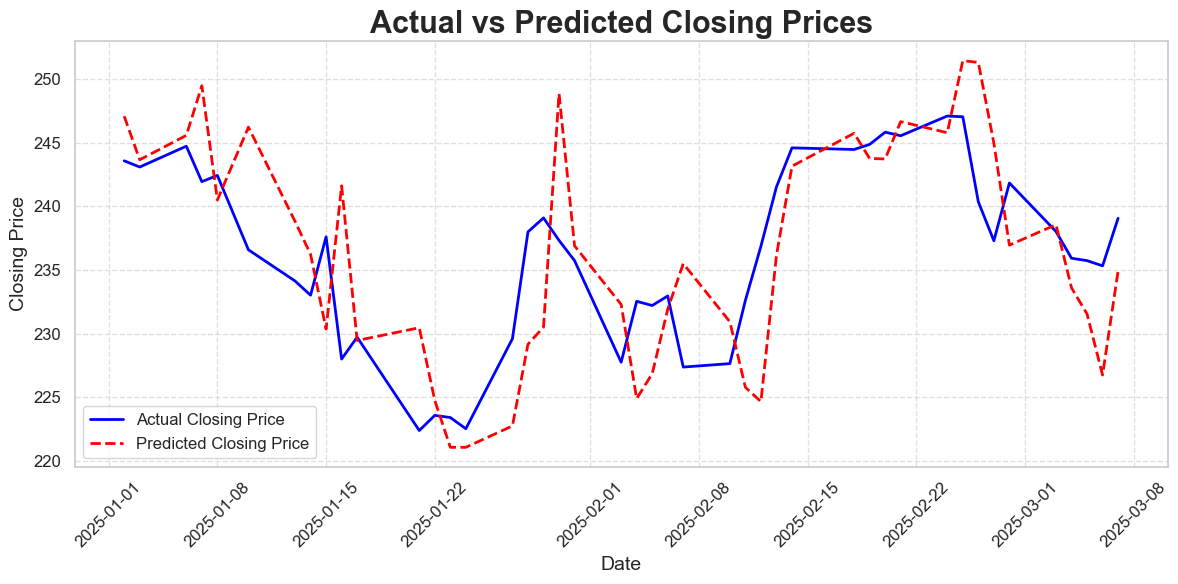

In [147]:
comparison_df = test_close.copy()
comparison_df['Predicted Close'] = test_prompts_predictions['close price prediction']
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Close'], label='Actual Closing Price', color='blue', linewidth=2)
plt.plot(comparison_df['Date'], comparison_df['Predicted Close'], label='Predicted Closing Price', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Closing Prices', fontsize=22, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Actual_vs_Predicted_Closing_Prices_Google.png', format='png', bbox_inches='tight')
plt.show()

In [148]:
total_end_time = time.time()
notebook_total_time = total_end_time - total_start_time
print(f"Notebook total runtime: {notebook_total_time:.4f} seconds")

Notebook total runtime: 35.8940 seconds
